### 2.3.1. Загрузка данных и первичный анализ

#### 1) Импортировать библиотеки: `pandas`, `numpy`, `scikit-learn` (модели, CV, метрики), `matplotlib` (для графиков).  

In [39]:
!pip install pandas numpy matplotlib scikit-learn
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, roc_auc_score, 
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    confusion_matrix
)
from sklearn.inspection import permutation_importance

import joblib

#### 2) Загрузить выбранный CSV в `pandas.DataFrame`.  

In [13]:
df = pd.read_csv('S06-hw-dataset-01.csv')

#### 3) Зафиксировать минимум:

##### - `head()`, `info()`, базовые статистики (`describe()` или аналог);

In [14]:
print(df.head())

   id     num01     num02     num03     num04     num05     num06     num07  \
0   1 -0.946058 -0.070313  1.824445 -2.754422  0.808865 -0.111094 -0.268950   
1   2 -2.484027  0.739378  1.596908 -2.586479 -0.033225 -3.054412 -4.706908   
2   3  1.522629  7.159635 -0.564903 -4.493110  1.623610  5.450187 -0.974595   
3   4  0.463373 -1.073908  1.752813  0.362786  2.790872  4.082385  0.322283   
4   5  3.188390 -4.701692 -0.689918 -0.448995  0.373821 -3.275363 -1.760931   

      num08     num09  ...     num20     num21     num22     num23     num24  \
0 -3.078210  0.801275  ... -1.616515 -1.989464  1.407390 -0.218362  2.016052   
1 -9.795169  0.145911  ... -1.727040 -0.583997  1.136761  0.285978 -0.310879   
2 -5.189589  1.600591  ...  0.524408  2.022430  1.278358 -0.850547  0.847457   
3  3.390984 -0.033929  ...  2.399834 -1.431576 -0.746987  0.049639  2.414689   
4  0.923689  0.537345  ... -2.183407 -2.896590  2.440343 -1.097168  1.457323   

   cat_contract  cat_region  cat_payment  te

In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [16]:
print(df.describe(include='all'))

                id         num01         num02         num03         num04  \
count  12000.00000  12000.000000  12000.000000  12000.000000  12000.000000   
mean    6000.50000      0.013705     -0.005278     -0.002357      0.038404   
std     3464.24595      2.096534      3.544498      1.004417      2.087318   
min        1.00000     -8.155181    -14.605579     -4.374043     -7.753301   
25%     3000.75000     -1.423844     -2.303772     -0.685618     -1.374579   
50%     6000.50000     -0.047565      0.053348     -0.009186      0.038766   
75%     9000.25000      1.422676      2.335937      0.671441      1.484417   
max    12000.00000      8.610863     16.299709      3.651692      7.571965   

              num05         num06         num07         num08         num09  \
count  12000.000000  12000.000000  12000.000000  12000.000000  12000.000000   
mean      -0.006301     -0.865297     -0.702877     -0.290694     -0.008154   
std        1.007329      3.888966      1.989513      3.45598

##### - распределение таргета `target` (доли классов);

In [19]:
target_counts = df['target'].value_counts()
target_ratios = df['target'].value_counts(normalize=True)
print(target_counts, "\n")
print(target_ratios)

target
0    8119
1    3881
Name: count, dtype: int64 

target
0    0.676583
1    0.323417
Name: proportion, dtype: float64


##### - (желательно) проверку пропусков и типы столбцов.

In [23]:
print(df.isnull().sum().sum()) # Всего пропусков

0


#### 4) Определить:

##### - `X` – признаки (все столбцы, кроме `target`; столбец `id` не использовать как признак);

In [27]:
X = df.drop(columns=['id', 'target'])
print(X.shape)

(12000, 28)


##### - `y` – таргет (`target`).

In [28]:
y = df.target
print(y.shape)

(12000,)


### 2.3.2. Train/Test-сплит и воспроизводимость

#### 1) Разделить данные на train/test:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Размеры выборок:")
print("train:", X_train.shape)
print("test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
train: (9600, 28)
test:  (2400, 28)

Распределение классов (train):
target
0    0.676562
1    0.323437
Name: proportion, dtype: float64

Распределение классов (test):
target
0    0.676667
1    0.323333
Name: proportion, dtype: float64


#### 2) Коротко пояснить, почему фиксированный seed и стратификация важны.

###### Фиксированный seed позволяет получать одинаковое разбиение данных при каждом запуске кода, а stratify=y необходим для сохранения доли классов в выборках. Это всё необходимо для классификации и отладки модели 

### 2.3.3. Baseline’ы


In [36]:
def print_metrics(y_true, y_pred, y_proba=None, title=None): # Вывод метрик
    if title:
        print(title)
    acc = accuracy_score(y_true, y_pred)
    pr = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy  = {acc:.4f}")
    print(f"precision = {pr:.4f}")
    print(f"f1        = {f1:.4f}")
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc = {auc:.4f}")
        except Exception:
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()

#### 1) `DummyClassifier` (например, `most_frequent` или `stratified`).  

In [41]:
dummy_cl = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_cl.fit(X_train, y_train)

y_pred_dummy = dummy_cl.predict(X_test)
y_proba_dummy = dummy_cl.predict_proba(X_test)[:, 1]

print_metrics(y_test, y_pred_dummy, y_proba_dummy)

accuracy  = 0.6767
precision = 0.0000
f1        = 0.0000
roc_auc = 0.5000
confusion_matrix:
[[1624    0]
 [ 776    0]]



#### 2) `LogisticRegression` (желательно через `Pipeline(StandardScaler + LogisticRegression)`).

In [45]:
log_reg_pipe = Pipeline([
  ("scaler", StandardScaler()),
  ("log_reg", LogisticRegression(max_iter=1000))
])

log_reg_pipe.fit(X_train, y_train)

y_pred_lgr = log_reg_pipe.predict(X_test)
y_proba_lgr = log_reg_pipe.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_pred_lgr, y_proba_lgr)

accuracy  = 0.8275
precision = 0.7828
f1        = 0.7076
roc_auc = 0.8747
confusion_matrix:
[[1485  139]
 [ 275  501]]



###### Исходя из результатов можно сделать вывод, что DummyClassifier смог предсказать только наиболее частый класс 0, в отличие от LogisticRegression, которая способна выявлять редкий класс 1

### 2.3.4. Модели недели 6 (обязательно)

#### - `DecisionTreeClassifier` 

In [52]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

dt_params = {
    'max_depth': [2, 4, 7, 8, 10],
    'min_samples_leaf': [1, 4, 6, 10],
}

dt_gs = GridSearchCV(dt, dt_params, cv=5, scoring='f1', n_jobs=-1)
dt_gs.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [2, 4, ...], 'min_samples_leaf': [1, 4, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 

#### - `RandomForestClassifier`  

In [53]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'max_depth': [4, 10, None],
    'min_samples_leaf': [1, 4, 6],
}
rf_gs = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_gs.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [4, 10, ...], 'min_samples_leaf': [1, 4, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3

#### - `GradientBoostingClassifier`

In [54]:
gb = GradientBoostingClassifier(random_state=42)
gb_params = {
    'min_samples_leaf': [2, 4],
    'max_depth': [3, 6],
}
gb_gs = GridSearchCV(gb, gb_params, cv=5, scoring='f1', n_jobs=-1)
gb_gs.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",GradientBoost...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [3, 6], 'min_samples_leaf': [2, 4]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold

In [59]:
models = {
    'DecisionTree': dt_gs.best_estimator_,
    'RandomForest': rf_gs.best_estimator_,
    'GradientBoosting': gb_gs.best_estimator_
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = f1_score(y_test, y_pred)

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nЛучшая модель по метрике f1: {best_model_name} ({results[best_model_name]:.4f})")


Лучшая модель по метрике f1: GradientBoosting (0.8887)


### 2.3.5. Метрики качества (обязательно)

In [63]:
all_metrics = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except (AttributeError, NotImplementedError):
        auc = None

    all_metrics[name] = {
        'accuracy': float(acc),
        'f1': float(f1),
        'roc_auc': float(auc) if auc is not None else None
    }
    
print("\nМетрики на тестовой выборке:")
for name, m in all_metrics.items():
    roc_str = f"{m['roc_auc']:.4f}" if m['roc_auc'] is not None else "N/A"
    print(f"{name:20} Accuracy: {m['accuracy']:.4f}, f1: {m['f1']:.4f}, ROC-AUC: {roc_str}")


Метрики на тестовой выборке:
DecisionTree         Accuracy: 0.8700, f1: 0.7895, ROC-AUC: 0.8949
RandomForest         Accuracy: 0.9258, f1: 0.8792, ROC-AUC: 0.9666
GradientBoosting     Accuracy: 0.9304, f1: 0.8887, ROC-AUC: 0.9696


### 2.3.6. Интерпретация (обязательно)

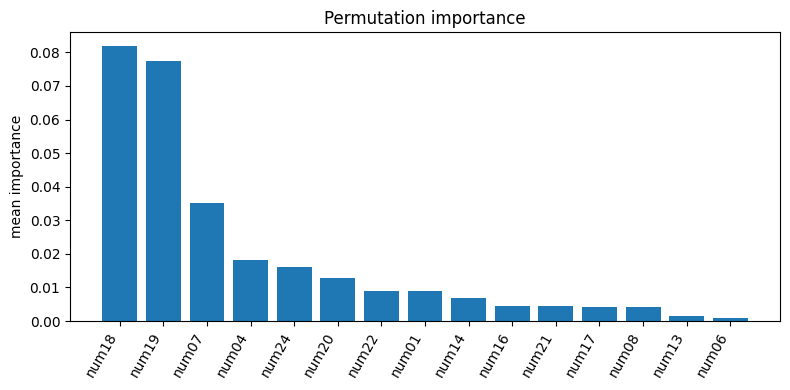

In [70]:
perm = permutation_importance(
    gb_gs, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

importances = perm.importances_mean
idx = np.argsort(importances)[::-1][:15]
feature_names = X.columns.astype(str).tolist()

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance")
plt.title("Permutation importance")
plt.tight_layout()
plt.savefig("./artifacts/figures/PermutationImportance.png")
plt.show()

##### Наибольшее влияние на качество классификации несут признаки `num18` и `num19